In [1]:
import matplotlib.pyplot as plt
import numpy as np

from testcases import TestCase

from domains import Waveguide, ScattererShape, ScattererType

# First Experiment (H convergence)

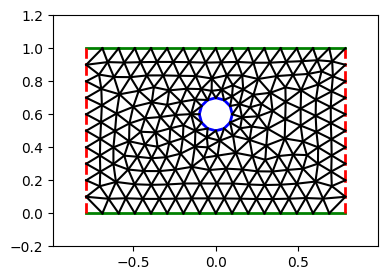

In [61]:
kappa_e = 8.
lambda_e = 2*np.pi/kappa_e
R = lambda_e
H = 1.
c = (0,0.6*H)
Domain = Waveguide(R=R,H=H)
Domain.add_scatterer( ScattererShape.CIRCLE, ScattererType.SOUND_SOFT, (c, 0.1*H))
Domain.generate_mesh(h_max=H/10)
Domain.plot_mesh()

In [62]:
from Trefft_tools import  TrefftzSpace
Nth = 5
th_0 = np.e/np.pi # no correct direction in the basis
#th = 0. # right direction in the basis
V = TrefftzSpace(Domain.Omega, Nth, {"Omega_i" : kappa_e , "Omega_e" : kappa_e}, th_0 )


In [63]:
from Trefft_tools import AssembleMatrix
N_modes = 20 #Number of modes for the DtN map
# "UWVF" parameters
a = 0.5
b = 0.5
d_1 = 0.5
d_2 = 0.5
A = AssembleMatrix(V, Domain.Edges, Np=N_modes, a=a, b=b, d_1=d_1, d_2=d_2)
NDOF = A.shape[0]
print(f'{NDOF} degrees of freedom.\n Matrix with {np.count_nonzero(A.toarray())} non-zero entries from a total of {NDOF**2}.\n "fullness" ratio: {np.count_nonzero(A.toarray())/NDOF**2 * 100 : .2f}%')

1960 degrees of freedom.
 Matrix with 42100 non-zero entries from a total of 3841600.
 "fullness" ratio:  1.10%


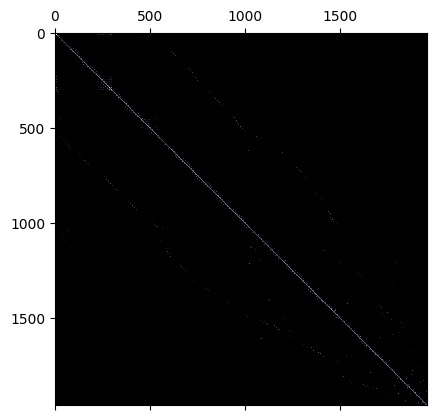

In [64]:
from checking_tools import plot_sparsity
plot_sparsity(A)

In [65]:
Ncond = np.linalg.cond(A.toarray())
Ncond

16998.203557714947

In [66]:
from Trefft_tools import AssembleGreenRHS
from exact_solutions import GreenFunctionModes

In [67]:
B = AssembleGreenRHS(V, Domain.Edges, kappa_e, H, a=a, y0=c[1], modes=True)

In [68]:
from Trefft_tools import TrefftzFunction
#this should be a "solve system"
from scipy.sparse.linalg import spsolve 
A = A.tocsc()
DOFs = spsolve(A,B)
f = TrefftzFunction(V,DOFs)

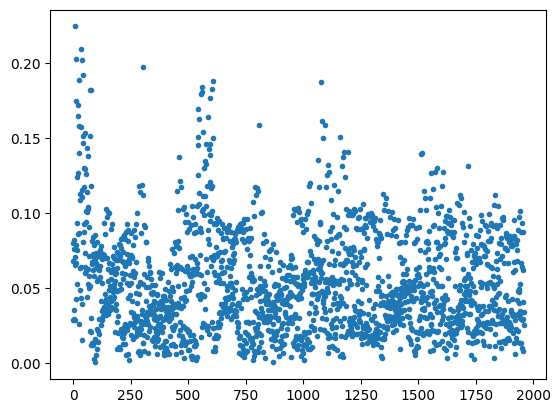

In [69]:
plt.plot(np.abs(DOFs),'.')

In [70]:
Ny = 50
Nx = 10*Ny
x = np.linspace(-R,R,Nx)
y = np.linspace(0,H,Ny)
X, Y = np.meshgrid(x,y)

# Z = np.reshape(f(X.ravel(), Y.ravel()), [Ny,Nx]) FIX THIS, EVALUATION SHOULD BE VECTORIZED

u_Trefft =  np.reshape([ f(x_, y_) for x_, y_ in zip( X.ravel(), Y.ravel()) ], [Ny,Nx])
u_exact = np.reshape( GreenFunctionModes(kappa_e,Domain.H, np.stack([X.ravel(),Y.ravel()], axis=1), c[0], c[1], M=20), (Ny,Nx))


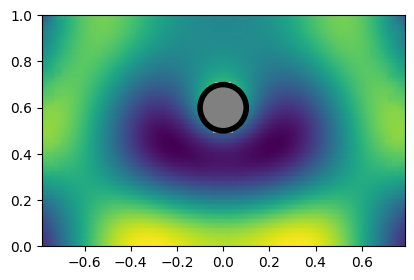

In [71]:

Domain.plot_field(X,Y,np.real(u_Trefft))

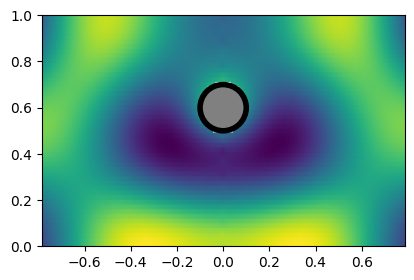

In [72]:
Domain.plot_field(X,Y,np.real(u_exact))

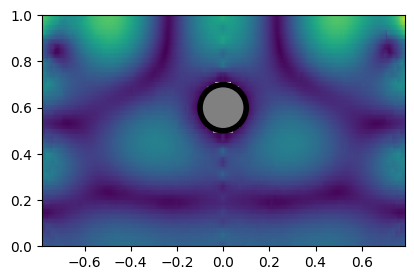

In [73]:
Domain.plot_field(X,Y,np.abs(u_Trefft-u_exact))
